## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import skimage

Prague grayscale

In [2]:
data_path = "data/Prague_Grayscale_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

Prague Colour


In [37]:
data_path = "data/Prague_Colour_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

PASTIS

In [11]:
data_path = "data/PASTIS/"
dataset_size = 20

imgs = [] ; masks = [] ; masks2 = []
for i in range(dataset_size):
    img = np.load(data_path + f"DATA_S2/S2_100{i//10}{i%10}.npy")[1,1,:,:]
    imgs.append(np.squeeze(img))
    masks.append(np.load(data_path + f"ANNOTATIONS/ParcelIDs_100{i//10}{i%10}.npy"))
    masks2.append(np.load(data_path + f"INSTANCE_ANNOTATIONS/HEATMAP_100{i//10}{i%10}.npy"))

In [12]:
print(imgs[0].shape)
print(masks[0].shape)
print(masks2[0].shape)

(128, 128)
(128, 128)
(128, 128)


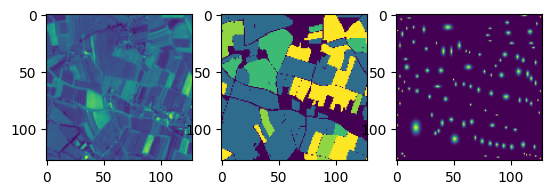

In [13]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(imgs[0])
axes[1].imshow(masks[0])
axes[2].imshow(masks2[0])


## Arivazhagan & Ganesan, 2003

Utility functions (feature extraction)

In [ ]:
def get_features(comat):
    n, k = comat.shape

    c = 0.0
    mx = 0.0
    my = 0.0

    for i in range(n):
        for j in range(k):
            c += (i - j) ** 2 * comat[i, j]
            mx += i * comat[i, j]
            my += j * comat[i, j]

    s = 0.0
    p = 0.0
    for i in range(n):
        for j in range(k):
            v = (i + j - mx - my)
            s += (v ** 3) * comat[i, j]
            p += (v ** 4) * comat[i, j]

    return c, s, p

def log_normalize(x, xmax):
    if xmax == 0:
        return 0.0
    return 255.0 * np.log1p(abs(x)) / np.log1p(abs(xmax))

def normalize(x, xmax):
    if xmax == 0:
        return 0.0
    return 255.0 * x / xmax

def compute_comat(band):
            band = band - band.min()
            band = band / (band.max() + 1e-12)
            band = (band * 15).astype(np.uint8)  # 16 levels

            C = skimage.feature.graycomatrix(
                band,
                distances=[1],
                angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                levels=16,
                symmetric=True,
                normed=True
            )

            return np.mean(C, axis=(2, 3))


Segmentation algorithm

In [ ]:
seg_imgs = []
imgs = [imgs[0]]
for img in imgs:

    w, h = img.shape
    if w % 32 != 0 or h % 32 != 0:
        raise Exception("Image size must be multiple of 32")

    blocks = []
    for i in range(0, w-32):
        for j in range(0, h-32):
            blocks.append(img[i:i+32, j:j+32])

    wavelet = pywt.Wavelet('db4')
    blocks_ft = []

    LL_cmax = LL_smax = LL_pmax = 0.0
    LH_cmax = LH_smax = LH_pmax = 0.0
    HL_cmax = HL_smax = HL_pmax = 0.0
    HH_cmax = HH_smax = HH_pmax = 0.0

    for block in blocks:

        LL, (LH, HL, HH) = pywt.wavedec2(block, wavelet, level=1)

        LL_comat = compute_comat(LL)
        LH_comat = compute_comat(LH)
        HL_comat = compute_comat(HL)
        HH_comat = compute_comat(HH)

        blk_features = {}

        blk_features['LL'] = get_features(LL_comat)
        blk_features['LH'] = get_features(LH_comat)
        blk_features['HL'] = get_features(HL_comat)
        blk_features['HH'] = get_features(HH_comat)

        LL_cmax = max(LL_cmax, blk_features['LL'][0])
        LL_smax = max(LL_smax, blk_features['LL'][1])
        LL_pmax = max(LL_pmax, blk_features['LL'][2])

        LH_cmax = max(LH_cmax, blk_features['LH'][0])
        LH_smax = max(LH_smax, blk_features['LH'][1])
        LH_pmax = max(LH_pmax, blk_features['LH'][2])

        HL_cmax = max(HL_cmax, blk_features['HL'][0])
        HL_smax = max(HL_smax, blk_features['HL'][1])
        HL_pmax = max(HL_pmax, blk_features['HL'][2])

        HH_cmax = max(HH_cmax, blk_features['HH'][0])
        HH_smax = max(HH_smax, blk_features['HH'][1])
        HH_pmax = max(HH_pmax, blk_features['HH'][2])

        blocks_ft.append(blk_features)

    for blk in blocks_ft:

        LLc, LLs, LLp = blk['LL']
        LHc, LHs, LHp = blk['LH']
        HLc, HLs, HLp = blk['HL']
        HHc, HHs, HHp = blk['HH']

        LL_sum = (
            normalize(LLc, LL_cmax) +
            log_normalize(LLs, LL_smax) +
            log_normalize(LLp, LL_pmax)
        )

        LH_sum = (
            normalize(LHc, LH_cmax) +
            log_normalize(LHs, LH_smax) +
            log_normalize(LHp, LH_pmax)
        )

        HL_sum = (
            normalize(HLc, HL_cmax) +
            log_normalize(HLs, HL_smax) +
            log_normalize(HLp, HL_pmax)
        )

        HH_sum = (
            normalize(HHc, HH_cmax) +
            log_normalize(HHs, HH_smax) +
            log_normalize(HHp, HH_pmax)
        )

        blk['SUM'] = LL_sum + LH_sum + HL_sum + HH_sum

    nbx = w - 32 + 1
    nby = h - 32 + 1
    seg = np.zeros((nbx, nby))

    i = 0; j = 0
    for idx in range(len(blocks) - nby):
        # Horizontal
        seg[i, j] += abs(
            blocks_ft[idx]['SUM'] -
            blocks_ft[idx + 1]['SUM']
        )

        # Vertical
        seg[i, j] += abs(
            blocks_ft[idx]['SUM'] -
            blocks_ft[idx + nby]['SUM']
        )

        j += 1
        if j > nby - 1:
            i += 1
            j = 0

    H, W = 512, 512
    blk_size = 32

    seg_pix = np.zeros((H, W), dtype=np.float64)
    weight = np.zeros((H, W), dtype=np.float64)

    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            seg_pix[i:i+blk_size, j:j+blk_size] += seg[i, j]
            weight[i:i+blk_size, j:j+blk_size] += 1

    seg_pix /= weight

    thresh = skimage.filters.threshold_otsu(seg_pix,nbins=16)
    seg_bin = (seg_pix > thresh).astype(np.uint8)

    # seg_img = np.kron(seg_bin, np.ones((480,480)))
    # seg_img = np.hstack(seg_bin,np.zeros((480,32)))
    # seg_img = np.vstack(seg_bin,np.zeros((32,512)))

    seg_img = seg_bin.copy()
    
    seg_img = skimage.morphology.opening(seg_img)
    seg_img = skimage.morphology.skeletonize(seg_img)

    seg_imgs.append(seg_img)


fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
idx = 0
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')


Mean F1 : 0.0
F1 std : 0.0


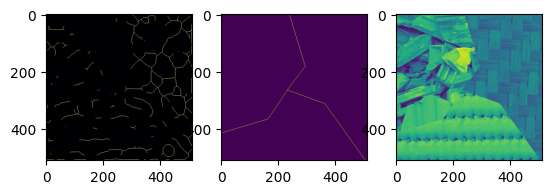

In [ ]:
from skimage.feature import graycomatrix
from skimage.util import view_as_windows
from skimage.filters import threshold_otsu
from skimage.morphology import disk, skeletonize
from skimage.filters.rank import mean

def get_features(C):
    """
    C : Normalized GLCM (16x16)
    """
    n, k = C.shape

    # Re-indexing to fit paper notation
    i = np.arange(1, n+1).reshape(-1, 1)
    j = np.arange(1, k+1).reshape(1, -1)

    # Means
    mx = np.sum(i * C)
    my = np.sum(j * C)

    # Contrast
    contrast = np.sum((i - j) ** 2 * C)

    # Cluster shade & Prominence
    v = (i - mx + j - my)
    shade = np.sum((v ** 3) * C)
    prominence = np.sum((v ** 4) * C)

    return contrast, shade, prominence


def compute_wcf_features(band):
    # NOrmalizing and quantifying (16 levels)
    band = band - band.min()
    band = band / (band.max() + 1e-12)
    band = (band * 15).astype(np.uint8)

    C = graycomatrix(
        band,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=16,
        symmetric=True,
        normed=True
    )

    feats = np.zeros((4, 3))
    for a in range(4):
        feats[a] = get_features(C[:, :, 0, a])

    return feats.mean(axis=0)


def extract_blocks(img, block_size=32):
    return view_as_windows(img, (block_size, block_size))


def extract_block_features(blocks, wavelet='db4'):
    nbx, nby = blocks.shape[:2]

    feats = np.zeros((nbx, nby, 4, 3))  # LL, LH, HL, HH × (c,s,p)

    for i in range(nbx):
        for j in range(nby):
            LL, (LH, HL, HH) = pywt.wavedec2(blocks[i, j], wavelet, level=1)

            feats[i, j, 0] = compute_wcf_features(LL)
            feats[i, j, 1] = compute_wcf_features(LH)
            feats[i, j, 2] = compute_wcf_features(HL)
            feats[i, j, 3] = compute_wcf_features(HH)

    return feats

def normalize_linear(x, xmax):
    return np.zeros_like(x) if xmax == 0 else 255 * x / xmax

def normalize_log(x, xmax):
    return np.zeros_like(x) if xmax == 0 else 255 * np.log1p(np.abs(x)) / np.log1p(np.abs(xmax)) # log(1+|x|)

def compute_segmentation_band(feats):
    # feats : (nbx, nby, 4 (subbands), 3 (features))
    nbx, nby = feats.shape[:2]

    seg = np.zeros((nbx, nby))

    for sb in range(4):
        c = feats[:, :, sb, 0]
        s = feats[:, :, sb, 1]
        p = feats[:, :, sb, 2]

        cN = normalize_linear(c, c.max())
        sN = normalize_log(s, s.max())
        pN = normalize_log(p, p.max())

        S = cN + sN + pN

        seg[:-1, :] += np.abs(S[:-1, :] - S[1:, :])
        seg[:, :-1] += np.abs(S[:, :-1] - S[:, 1:])

    return seg


def post_process(seg, img_shape, blk_size=32):
    H, W = img_shape
    seg_pix = np.zeros((H, W))
    weight = np.zeros((H, W))

    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            seg_pix[i:i+blk_size, j:j+blk_size] += seg[i, j]
            weight[i:i+blk_size, j:j+blk_size] += 1

    seg_pix /= weight

    # Disk filtering
    seg_f = mean(seg_pix.astype(np.uint8), disk(3))

    thresh = threshold_otsu(seg_f)
    seg_bin = seg_f > thresh

    return skeletonize(seg_bin)


def texture_segmentation(img):
    blocks = extract_blocks(img, 32)
    feats = extract_block_features(blocks,wavelet='haar')
    seg = compute_segmentation_band(feats)
    return post_process(seg, img.shape)


### SEGMENTATION (>7 min for 1 image : caution)
seg_imgs = []
for img in imgs:
    seg_imgs.append(texture_segmentation(img))
# seg_imgs.append(texture_segmentation(imgs[0]))

fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
# idx = 0
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')

## Multi Otsu

Mean F1 : 0.0
F1 std : 0.0


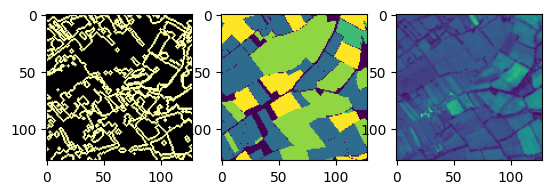

In [14]:
seg_imgs = []
for img in imgs:
    smth_img = skimage.filters.median(img)
    threshs = skimage.filters.threshold_multiotsu(smth_img)
    seg = np.digitize(img,bins=threshs)
    # mask = np.zeros(seg.shape)
    # for i in range(len(threshs)):
    #     contours = skimage.measure.find_contours(seg,level=i)
    #     for contour in contours:
    #         mask[contour.astype(np.int32)] += 1
    seg = skimage.morphology.closing(seg)
    mask = skimage.segmentation.find_boundaries(seg)
    seg_imgs.append(mask)

fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')


## SLIC

Mean F1 : nan
F1 std : nan


C:\Users\yannc\AppData\Local\Temp\ipykernel_28616\752877647.py:24: RuntimeWarning: invalid value encountered in scalar divide
  F1.append(2*TP / (2*TP + FP + FN))


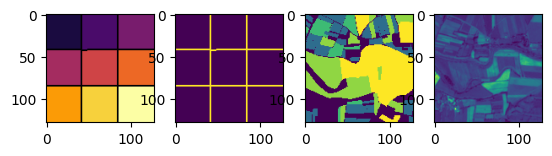

In [16]:
from skimage.segmentation import slic

seg_imgs = []
seg_masks = []
for img in imgs:

    # segments = slic(img,n_segments = 10,compactness = 20)
    segments = slic(img,n_segments = 10,compactness = 10,channel_axis=None)
    mask = skimage.segmentation.find_boundaries(segments)
    seg = skimage.measure.label(mask,background=1)
    seg_imgs.append(seg)
    seg_masks.append(mask)

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    true_mask = skimage.morphology.dilation(masks[i],skimage.morphology.disk(3))
    pred_mask = skimage.morphology.dilation(seg_imgs[i],skimage.morphology.disk(3))
    TP = np.sum((true_mask == 1) & (pred_mask == 1))
    FN = np.sum((true_mask == 1) & (pred_mask == 0))
    FP = np.sum((true_mask == 0) & (pred_mask == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')

fig, axes = plt.subplots(ncols=4)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(seg_masks[idx])
axes[2].imshow(masks[idx])
axes[3].imshow(imgs[idx])

## Split&Merge

In [ ]:
seg_imgs = []
for img in imgs:
    